# Fashion Recommendation System
[Data Information]   
Data Source: https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=78   
Raw Data Type : 720x1280x24b

[Image]   
Item-Image : n장   
Model-Image : m장

[Version]   
64 nodes added Convolutional AE, 128x128x3

## 0. Setting

### Goole Drive Connecting

In [ ]:
pwd

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Code Lion/Final'

/content/drive/MyDrive/Code Lion/Final


In [ ]:
!ls

 data					       'low version'
'Fashion Recommendation System Develop.ipynb'   model_save
'Fashion Recommendation System Main.ipynb'      sample.jpg
 figure					        Training-checkpoint
'latent feature'


### Library Call

In [1]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [2]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# 상용 라이브러리
from glob import glob
import os
import cv2
import pandas as pd
import numpy as np
import datetime as dt
import time

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

# 한글 폰트 패치
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   

# 시각화 포맷 설정
plt.style.use("ggplot")
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# sckit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, pairwise_distances

# Tensorflow 라이브러리
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import tensorflow_addons as tfa
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization
from keras import layers, models
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### User Function Definition

In [4]:
# -------------Image Load & Preprocessing ------------- #
# Global Constant Definition
imgR = 128
imgC = 128
channel = 3
crop_y = (250,1000)
crop_x = (40,680)
root_dir = '/content/drive/MyDrive/Code Lion/Final/data'

# Single Image Load
def img_read(file):
  img = cv2.imread(file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# Gamma Correction
def adjust_gamma(img, gamma=1.0): # 감마 보정 함수
    invGamma = 1.0 / gamma
    out = img.copy().astype(np.float)
    out = ((out / 255) ** invGamma) * 255
    return out.astype(np.uint8)

# Image Crop & Resize
def img_crop(img):
    # 개선점
    img = img[crop_y[0]:crop_y[1], crop_x[0]:crop_x[1]]
    img = cv2.resize(img, (imgR,imgC), cv2.INTER_LINEAR)
    return img

# New Sample Image Preprocessing
def New_image_preprocessing(file_name):
  smp = img_read(file_name)
  smp = cv2.resize(smp, (imgR,imgC), cv2.INTER_LINEAR)
  smp = adjust_gamma(smp, 0.8)
  smp = smp/255.0
  return smp

# Load All img from folder
def load_img_folder():
    # 의상의 전방부 사진만 가져오기
    wfiles = sorted(glob(f'{root_dir}/*_F.jpg'))
    img_list = []
    label_list = []
    for file in wfiles:
        img = img_read(file)
        img = img_crop(img)
        img = adjust_gamma(img, 0.8)
        img_list.append(img)
        label_list.append(file.split('/')[-1])
    return np.array(img_list), label_list

# -------------Image EDA & Visualization ------------- #

# plot_images
def plot_images(nRow, nCol, img_set):
  fig = plt.figure()
  fig, ax = plt.subplots(nRow, nCol, figsize=(nCol*4,nRow*4))
  k=0
  for i in range(nRow):
    for j in range(nCol):
      if nRow <= 1 : axis = ax[j]
      else:          axis = ax[i,j]
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(img_set[k+j])
      plt.axis('off')
    k += nCol
  plt.show()

# Top10 유사 이미지 시각화
def top10_visualize(img_set,top10_idx):
  fig = plt.figure()
  fig, ax = plt.subplots(2, 5, figsize=(5*3,2*3))
  plt.suptitle('Top10 Similar Images',size=20)
  k=0
  for i in range(2):
    for j in range(5):
      axis = ax[i,j]
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(img_set[top10_idx[i+j]])
      plt.axis('off')
    k += 5
  plt.show()

# ------------- Model Function ------------- #
def Reconstruction_Error(X_test,X_pred):
  error_list = []
  for i in range(len(X_test)):
    ele = np.mean(np.power(X_test[i] - X_pred[i], 2),axis=1).mean()
    error_list.append(ele)
  return error_list

def AVGpooling(raw_feature):
  result = []
  for i in range(raw_feature.shape[0]):
    row= []
    for j in range(raw_feature.shape[-1]):
      row.append(raw_feature[i,:,:,j].mean())
    result.append(row)
  return np.array(result)

## 1. Data Load

In [ ]:
# Image DataSet Load
img_set, label_set = load_img_folder()
print('img_set.shape :',img_set.shape)
print('label_set.shape :',len(label_set))

img_set.shape : (123, 128, 128, 3)
label_set.shape : 123


In [ ]:
# Image Information
type(img_set), round(img_set.mean(),4)

(numpy.ndarray, 216.6684)

In [ ]:
# Label Information
type(label_set), label_set[:4]

(list, ['1008002_F.jpg', '1008003_F.jpg', '1012144_F.jpg', '1012188_F.jpg'])

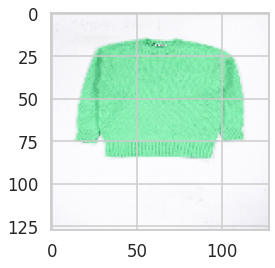

In [ ]:
# Image Sample
plt.imshow(img_set[100])

<Figure size 432x288 with 0 Axes>

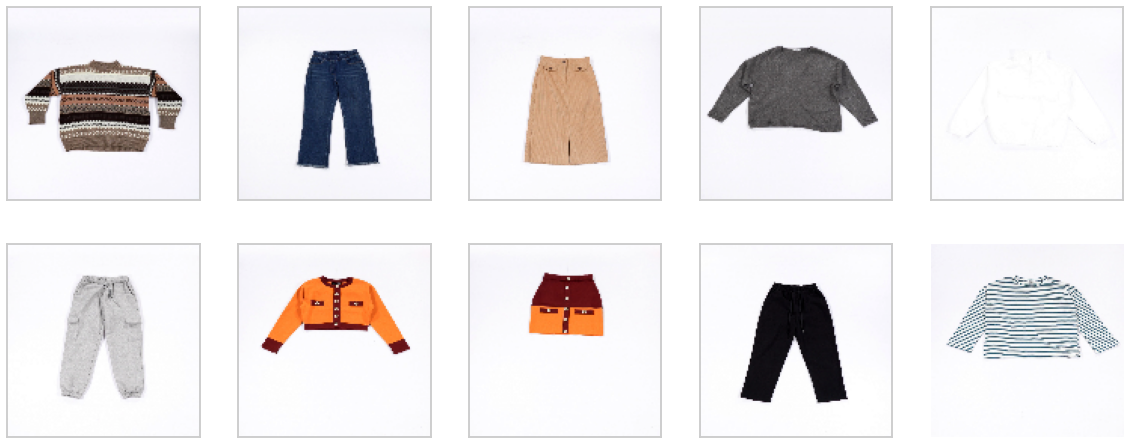

In [ ]:
# Multi Image Samples
_ = plot_images(2,5,img_set)

## 2. Data Preprocessing

In [ ]:
# Data Normalization
img_scaled = img_set/255
print('Raw Image Format :',img_set.shape, img_set.mean())
print('Scaled Image Format :',img_scaled.shape, img_scaled.mean())

Raw Image Format : (123, 128, 128, 3) 216.66844429491658
Scaled Image Format : (123, 128, 128, 3) 0.8496801737055546


In [ ]:
# Train, Test Data Split
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(img_scaled, label_set, random_state=42, test_size=0.2, shuffle=True)
print(X_train.shape, len(y_train))
print(X_test.shape, len(y_test))

(98, 128, 128, 3) 98
(25, 128, 128, 3) 25


## 3. Convolutional Autoencoder Modeling

### Encoder

In [7]:
# Encoder Part Modeling
tensorflow.keras.backend.clear_session()
encoder_input = Input(shape=(imgR,imgC,channel))

# Fisrt ConvPooling Layer : 128
L1 = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_input)
L2 = MaxPooling2D((2, 2))(L1)

# Second ConvPooling Layer : 64
L3 = Conv2D(64, (3, 3), activation='relu', padding='same')(L2)
L4 = Conv2D(64, (3, 3), activation='relu', padding='same')(L3)
L5 = BatchNormalization()(L4)
L6 = MaxPooling2D((2, 2))(L5)

# Third ConvPooling Layer : 32
L7 = Conv2D(32, (3, 3), activation='relu', padding='same')(L6)
L8 = Conv2D(32, (3, 3), activation='relu', padding='same')(L7)
L9 = BatchNormalization()(L8)
L10 = MaxPooling2D((2, 2))(L9)

# Fourth ConvPooling Layer : 16
L11 = Conv2D(16, (3, 3), activation='relu', padding='same')(L10)
L12 = Conv2D(16, (3, 3), activation='relu', padding='same')(L11)
L13 = BatchNormalization()(L12)
L14 = MaxPooling2D((2, 2))(L13)

# Fifth ConvPooling Layer : 8
L15 = Conv2D(8, (3, 3), activation='relu', padding='same')(L14)
L16 = MaxPooling2D((2, 2))(L15)

encoder_output = L16

In [8]:
# Encoder Summary()
encoder = keras.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                               

In [ ]:
# Plot Encoder Diagram
plot_model(encoder, to_file='figure/Eecoder0817.png', show_shapes=True)

### Decoder

In [9]:
# Decoder Part Modeling
decoder_input = Input(shape=(4,4,8))  # Decoder의 Input Shape는 Hard Coding이 필요함. (개선점)

# First ConvPooling Layer : 8
L17 = Conv2D(8, (3, 3), activation='relu', padding='same')(decoder_input)
L18 = UpSampling2D((2, 2))(L17)

# Second ConvPooling Layer : 16
L19 = Conv2D(16, (3, 3), activation='relu', padding='same')(L18)
L20 = Conv2D(16, (3, 3), activation='relu', padding='same')(L19)
L21 = BatchNormalization()(L20)
L22 = UpSampling2D((2, 2))(L21)

# Third ConvPooling Layer : 32
L23 = Conv2D(32, (3, 3), activation='relu', padding='same')(L22)
L24 = Conv2D(32, (3, 3), activation='relu', padding='same')(L23)
L25 = BatchNormalization()(L24)
L26 = UpSampling2D((2, 2))(L25)

# Fourth ConvPooling Layer : 64
L27 = Conv2D(64, (3, 3), activation='sigmoid', padding='same')(L26)
L28 = Conv2D(64, (3, 3), activation='relu', padding='same')(L27)
L29 = BatchNormalization()(L28)
L30 = UpSampling2D((2, 2))(L29)

# Fifth ConvPooling Layer : 128
L31 = Conv2D(128, (3, 3), activation='sigmoid', padding='same')(L30)
L32 = UpSampling2D((2, 2))(L31)

# Sixth ConvPooling Layer : 3
L33 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(L32)

decoder_output = L33

In [10]:
# Decoder Summary()
decoder = keras.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 4, 8)]         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 16)          1168      
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 16)          2320      
                                                                 
 batch_normalization_3 (Batc  (None, 8, 8, 16)         64        
 hNormalization)                                           

In [ ]:
# Plot Decoder Diagram
plot_model(decoder, to_file='figure/Decoder0817.png', show_shapes=True)

### AutoEncoder (Encoder + Decoder)

In [11]:
# Convolutional Autoencoder Modeling
# Connecting Encoder & Decoder Part

init_input = Input(shape=(imgR,imgC,channel))
connect_input = encoder(init_input)
connect_output = decoder(connect_input)

model = keras.Model(init_input, connect_output)

In [12]:
# Model Compile
model.compile(optimizer='Adam',loss='binary_crossentropy')

In [13]:
# Convolutional Autoencoder Summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 model (Functional)          (None, 4, 4, 8)           150568    
                                                                 
 model_1 (Functional)        (None, 128, 128, 3)       151147    
                                                                 
Total params: 301,715
Trainable params: 301,267
Non-trainable params: 448
_________________________________________________________________


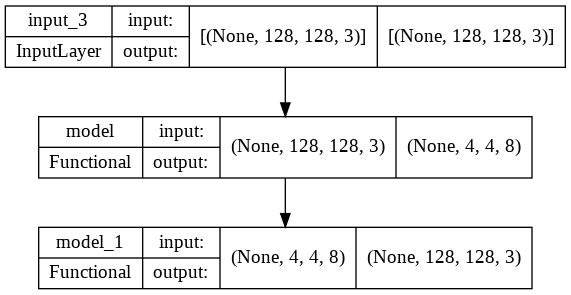

In [ ]:
# Plot ConvAE Diagram
plot_model(model, to_file='figure/ConvAE0817.png', show_shapes=True)

In [ ]:
# Checkpoint Callback Function Definition
checkpoint_dir = 'Training-checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'

# 10번 에포크씩 val_loss 변화 확인- 변화 없을 시 학습 중단
patience_epoch = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=patience_epoch)
cp = ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                     save_weights_only=True,
                     save_best_only=True)

In [ ]:
# TQDM Tracking Conv-AE Model Training
nb_epochs = 100
batch_size = 10

start = time.time()
tqdm_callback = tfa.callbacks.TQDMProgressBar()
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, shuffle=True,
                    callbacks=[early_stopping, cp, tqdm_callback], validation_split=0.05).history
end = time.time()

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/10           ETA: ?s - 

Epoch 1/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.4516
Epoch 1: val_loss improved from inf to 0.44546, saving model to Training-checkpoint/cp-0001-0.45.ckpt
10/10 [==============================] - 2s 81ms/step - loss: 0.4483 - val_loss: 0.4455
Epoch 2/100


0/10           ETA: ?s - 

Epoch 2/100
 8/10 [=======================>......] - ETA: 0s - loss: 0.3082
Epoch 2: val_loss did not improve from 0.44546
10/10 [==============================] - 0s 26ms/step - loss: 0.3041 - val_loss: 0.5499
Epoch 3/100


0/10           ETA: ?s - 

Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.2989
Epoch 3: val_loss did not improve from 0.44546
10/10 [==============================] - 0s 25ms/step - loss: 0.2989 - val_loss: 0.5990
Epoch 4/100


0/10           ETA: ?s - 

Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.2851
Epoch 4: val_loss did not improve from 0.44546
10/10 [==============================] - 0s 25ms/step - loss: 0.2851 - val_loss: 0.6336
Epoch 5/100


0/10           ETA: ?s - 

Epoch 5/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.2773
Epoch 5: val_loss did not improve from 0.44546
10/10 [==============================] - 0s 25ms/step - loss: 0.2780 - val_loss: 0.5269
Epoch 6/100


0/10           ETA: ?s - 

Epoch 6/100
10/10 [==============================] - ETA: 0s - loss: 0.2714
Epoch 6: val_loss did not improve from 0.44546
10/10 [==============================] - 0s 24ms/step - loss: 0.2714 - val_loss: 0.4765
Epoch 7/100


0/10           ETA: ?s - 

Epoch 7/100
10/10 [==============================] - ETA: 0s - loss: 0.2755
Epoch 7: val_loss improved from 0.44546 to 0.43922, saving model to Training-checkpoint/cp-0007-0.44.ckpt
10/10 [==============================] - 0s 38ms/step - loss: 0.2755 - val_loss: 0.4392
Epoch 8/100


0/10           ETA: ?s - 

Epoch 8/100
10/10 [==============================] - ETA: 0s - loss: 0.2726
Epoch 8: val_loss improved from 0.43922 to 0.42508, saving model to Training-checkpoint/cp-0008-0.43.ckpt
10/10 [==============================] - 0s 39ms/step - loss: 0.2726 - val_loss: 0.4251
Epoch 9/100


0/10           ETA: ?s - 

Epoch 9/100
10/10 [==============================] - ETA: 0s - loss: 0.2702
Epoch 9: val_loss improved from 0.42508 to 0.41625, saving model to Training-checkpoint/cp-0009-0.42.ckpt
10/10 [==============================] - 0s 37ms/step - loss: 0.2702 - val_loss: 0.4162
Epoch 10/100


0/10           ETA: ?s - 

Epoch 10/100
10/10 [==============================] - ETA: 0s - loss: 0.2689
Epoch 10: val_loss improved from 0.41625 to 0.40379, saving model to Training-checkpoint/cp-0010-0.40.ckpt
10/10 [==============================] - 0s 35ms/step - loss: 0.2689 - val_loss: 0.4038
Epoch 11/100


0/10           ETA: ?s - 

Epoch 11/100
10/10 [==============================] - ETA: 0s - loss: 0.2703
Epoch 11: val_loss improved from 0.40379 to 0.38783, saving model to Training-checkpoint/cp-0011-0.39.ckpt
10/10 [==============================] - 0s 38ms/step - loss: 0.2703 - val_loss: 0.3878
Epoch 12/100


0/10           ETA: ?s - 

Epoch 12/100
10/10 [==============================] - ETA: 0s - loss: 0.2641
Epoch 12: val_loss improved from 0.38783 to 0.37455, saving model to Training-checkpoint/cp-0012-0.37.ckpt
10/10 [==============================] - 0s 36ms/step - loss: 0.2641 - val_loss: 0.3746
Epoch 13/100


0/10           ETA: ?s - 

Epoch 13/100
10/10 [==============================] - ETA: 0s - loss: 0.2601
Epoch 13: val_loss did not improve from 0.37455
10/10 [==============================] - 0s 24ms/step - loss: 0.2601 - val_loss: 0.3785
Epoch 14/100


0/10           ETA: ?s - 

Epoch 14/100
10/10 [==============================] - ETA: 0s - loss: 0.2589
Epoch 14: val_loss improved from 0.37455 to 0.36262, saving model to Training-checkpoint/cp-0014-0.36.ckpt
10/10 [==============================] - 0s 37ms/step - loss: 0.2589 - val_loss: 0.3626
Epoch 15/100


0/10           ETA: ?s - 

Epoch 15/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.2618
Epoch 15: val_loss did not improve from 0.36262
10/10 [==============================] - 0s 25ms/step - loss: 0.2621 - val_loss: 0.3758
Epoch 16/100


0/10           ETA: ?s - 

Epoch 16/100
10/10 [==============================] - ETA: 0s - loss: 0.2551
Epoch 16: val_loss did not improve from 0.36262
10/10 [==============================] - 0s 24ms/step - loss: 0.2551 - val_loss: 0.4132
Epoch 17/100


0/10           ETA: ?s - 

Epoch 17/100
10/10 [==============================] - ETA: 0s - loss: 0.2582
Epoch 17: val_loss improved from 0.36262 to 0.35452, saving model to Training-checkpoint/cp-0017-0.35.ckpt
10/10 [==============================] - 0s 39ms/step - loss: 0.2582 - val_loss: 0.3545
Epoch 18/100


0/10           ETA: ?s - 

Epoch 18/100
 7/10 [====================>.........] - ETA: 0s - loss: 0.2522
Epoch 18: val_loss did not improve from 0.35452
10/10 [==============================] - 0s 23ms/step - loss: 0.2607 - val_loss: 0.3578
Epoch 19/100


0/10           ETA: ?s - 

Epoch 19/100
10/10 [==============================] - ETA: 0s - loss: 0.2596
Epoch 19: val_loss improved from 0.35452 to 0.34705, saving model to Training-checkpoint/cp-0019-0.35.ckpt
10/10 [==============================] - 0s 36ms/step - loss: 0.2596 - val_loss: 0.3471
Epoch 20/100


0/10           ETA: ?s - 

Epoch 20/100
 7/10 [====================>.........] - ETA: 0s - loss: 0.2571
Epoch 20: val_loss did not improve from 0.34705
10/10 [==============================] - 0s 24ms/step - loss: 0.2573 - val_loss: 0.3483
Epoch 21/100


0/10           ETA: ?s - 

Epoch 21/100
10/10 [==============================] - ETA: 0s - loss: 0.2507
Epoch 21: val_loss improved from 0.34705 to 0.32681, saving model to Training-checkpoint/cp-0021-0.33.ckpt
10/10 [==============================] - 0s 36ms/step - loss: 0.2507 - val_loss: 0.3268
Epoch 22/100


0/10           ETA: ?s - 

Epoch 22/100
10/10 [==============================] - ETA: 0s - loss: 0.2567
Epoch 22: val_loss did not improve from 0.32681
10/10 [==============================] - 0s 24ms/step - loss: 0.2567 - val_loss: 0.3293
Epoch 23/100


0/10           ETA: ?s - 

Epoch 23/100
10/10 [==============================] - ETA: 0s - loss: 0.2504
Epoch 23: val_loss improved from 0.32681 to 0.31434, saving model to Training-checkpoint/cp-0023-0.31.ckpt
10/10 [==============================] - 0s 40ms/step - loss: 0.2504 - val_loss: 0.3143
Epoch 24/100


0/10           ETA: ?s - 

Epoch 24/100
 8/10 [=======================>......] - ETA: 0s - loss: 0.2474
Epoch 24: val_loss did not improve from 0.31434
10/10 [==============================] - 0s 25ms/step - loss: 0.2504 - val_loss: 0.3281
Epoch 25/100


0/10           ETA: ?s - 

Epoch 25/100
10/10 [==============================] - ETA: 0s - loss: 0.2526
Epoch 25: val_loss did not improve from 0.31434
10/10 [==============================] - 0s 25ms/step - loss: 0.2526 - val_loss: 0.3253
Epoch 26/100


0/10           ETA: ?s - 

Epoch 26/100
10/10 [==============================] - ETA: 0s - loss: 0.2545
Epoch 26: val_loss did not improve from 0.31434
10/10 [==============================] - 0s 24ms/step - loss: 0.2545 - val_loss: 0.3234
Epoch 27/100


0/10           ETA: ?s - 

Epoch 27/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.2527
Epoch 27: val_loss did not improve from 0.31434
10/10 [==============================] - 0s 25ms/step - loss: 0.2544 - val_loss: 0.3310
Epoch 28/100


0/10           ETA: ?s - 

Epoch 28/100
10/10 [==============================] - ETA: 0s - loss: 0.2548
Epoch 28: val_loss did not improve from 0.31434
10/10 [==============================] - 0s 24ms/step - loss: 0.2548 - val_loss: 0.3162
Epoch 29/100


0/10           ETA: ?s - 

Epoch 29/100
10/10 [==============================] - ETA: 0s - loss: 0.2497
Epoch 29: val_loss improved from 0.31434 to 0.31113, saving model to Training-checkpoint/cp-0029-0.31.ckpt
10/10 [==============================] - 0s 39ms/step - loss: 0.2497 - val_loss: 0.3111
Epoch 30/100


0/10           ETA: ?s - 

Epoch 30/100
10/10 [==============================] - ETA: 0s - loss: 0.2500
Epoch 30: val_loss did not improve from 0.31113
10/10 [==============================] - 0s 25ms/step - loss: 0.2500 - val_loss: 0.3158
Epoch 31/100


0/10           ETA: ?s - 

Epoch 31/100
10/10 [==============================] - ETA: 0s - loss: 0.2538
Epoch 31: val_loss improved from 0.31113 to 0.30863, saving model to Training-checkpoint/cp-0031-0.31.ckpt
10/10 [==============================] - 0s 36ms/step - loss: 0.2538 - val_loss: 0.3086
Epoch 32/100


0/10           ETA: ?s - 

Epoch 32/100
10/10 [==============================] - ETA: 0s - loss: 0.2488
Epoch 32: val_loss improved from 0.30863 to 0.30686, saving model to Training-checkpoint/cp-0032-0.31.ckpt
10/10 [==============================] - 0s 39ms/step - loss: 0.2488 - val_loss: 0.3069
Epoch 33/100


0/10           ETA: ?s - 

Epoch 33/100
10/10 [==============================] - ETA: 0s - loss: 0.2494
Epoch 33: val_loss improved from 0.30686 to 0.29924, saving model to Training-checkpoint/cp-0033-0.30.ckpt
10/10 [==============================] - 0s 37ms/step - loss: 0.2494 - val_loss: 0.2992
Epoch 34/100


0/10           ETA: ?s - 

Epoch 34/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.2475
Epoch 34: val_loss did not improve from 0.29924
10/10 [==============================] - 0s 25ms/step - loss: 0.2488 - val_loss: 0.3010
Epoch 35/100


0/10           ETA: ?s - 

Epoch 35/100
10/10 [==============================] - ETA: 0s - loss: 0.2466
Epoch 35: val_loss did not improve from 0.29924
10/10 [==============================] - 0s 24ms/step - loss: 0.2466 - val_loss: 0.3099
Epoch 36/100


0/10           ETA: ?s - 

Epoch 36/100
10/10 [==============================] - ETA: 0s - loss: 0.2485
Epoch 36: val_loss did not improve from 0.29924
10/10 [==============================] - 0s 43ms/step - loss: 0.2485 - val_loss: 0.3010
Epoch 37/100


0/10           ETA: ?s - 

Epoch 37/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.2479
Epoch 37: val_loss did not improve from 0.29924
10/10 [==============================] - 0s 33ms/step - loss: 0.2483 - val_loss: 0.3016
Epoch 38/100


0/10           ETA: ?s - 

Epoch 38/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.2447
Epoch 38: val_loss did not improve from 0.29924
10/10 [==============================] - 0s 26ms/step - loss: 0.2475 - val_loss: 0.2994
Epoch 39/100


0/10           ETA: ?s - 

Epoch 39/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.2434
Epoch 39: val_loss improved from 0.29924 to 0.29436, saving model to Training-checkpoint/cp-0039-0.29.ckpt
10/10 [==============================] - 1s 71ms/step - loss: 0.2469 - val_loss: 0.2944
Epoch 40/100


0/10           ETA: ?s - 

Epoch 40/100
10/10 [==============================] - ETA: 0s - loss: 0.2632
Epoch 40: val_loss did not improve from 0.29436
10/10 [==============================] - 0s 24ms/step - loss: 0.2632 - val_loss: 0.2974
Epoch 41/100


0/10           ETA: ?s - 

Epoch 41/100
10/10 [==============================] - ETA: 0s - loss: 0.2594
Epoch 41: val_loss improved from 0.29436 to 0.29106, saving model to Training-checkpoint/cp-0041-0.29.ckpt
10/10 [==============================] - 0s 36ms/step - loss: 0.2594 - val_loss: 0.2911
Epoch 42/100


0/10           ETA: ?s - 

Epoch 42/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.2476
Epoch 42: val_loss did not improve from 0.29106
10/10 [==============================] - 0s 26ms/step - loss: 0.2492 - val_loss: 0.3564
Epoch 43/100


0/10           ETA: ?s - 

Epoch 43/100
10/10 [==============================] - ETA: 0s - loss: 0.2482
Epoch 43: val_loss did not improve from 0.29106
10/10 [==============================] - 0s 25ms/step - loss: 0.2482 - val_loss: 0.3684
Epoch 44/100


0/10           ETA: ?s - 

Epoch 44/100
10/10 [==============================] - ETA: 0s - loss: 0.2453
Epoch 44: val_loss did not improve from 0.29106
10/10 [==============================] - 0s 24ms/step - loss: 0.2453 - val_loss: 0.3457
Epoch 45/100


0/10           ETA: ?s - 

Epoch 45/100
10/10 [==============================] - ETA: 0s - loss: 0.2433
Epoch 45: val_loss did not improve from 0.29106
10/10 [==============================] - 0s 25ms/step - loss: 0.2433 - val_loss: 0.3028
Epoch 46/100


0/10           ETA: ?s - 

Epoch 46/100
10/10 [==============================] - ETA: 0s - loss: 0.2482
Epoch 46: val_loss did not improve from 0.29106
10/10 [==============================] - 0s 24ms/step - loss: 0.2482 - val_loss: 0.3413
Epoch 47/100


0/10           ETA: ?s - 

Epoch 47/100
10/10 [==============================] - ETA: 0s - loss: 0.2490
Epoch 47: val_loss did not improve from 0.29106
10/10 [==============================] - 0s 25ms/step - loss: 0.2490 - val_loss: 0.3899
Epoch 48/100


0/10           ETA: ?s - 

Epoch 48/100
10/10 [==============================] - ETA: 0s - loss: 0.2420
Epoch 48: val_loss did not improve from 0.29106
10/10 [==============================] - 0s 27ms/step - loss: 0.2420 - val_loss: 0.3848
Epoch 49/100


0/10           ETA: ?s - 

Epoch 49/100
10/10 [==============================] - ETA: 0s - loss: 0.2431
Epoch 49: val_loss did not improve from 0.29106
10/10 [==============================] - 0s 25ms/step - loss: 0.2431 - val_loss: 0.3627
Epoch 50/100


0/10           ETA: ?s - 

Epoch 50/100
10/10 [==============================] - ETA: 0s - loss: 0.2438
Epoch 50: val_loss did not improve from 0.29106
10/10 [==============================] - 0s 24ms/step - loss: 0.2438 - val_loss: 0.3119
Epoch 51/100


0/10           ETA: ?s - 

Epoch 51/100
10/10 [==============================] - ETA: 0s - loss: 0.2435
Epoch 51: val_loss did not improve from 0.29106
10/10 [==============================] - 0s 25ms/step - loss: 0.2435 - val_loss: 0.3258
Epoch 52/100


0/10           ETA: ?s - 

Epoch 52/100
 8/10 [=======================>......] - ETA: 0s - loss: 0.2439
Epoch 52: val_loss did not improve from 0.29106
10/10 [==============================] - 0s 28ms/step - loss: 0.2426 - val_loss: 0.3398
Epoch 53/100


0/10           ETA: ?s - 

Epoch 53/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.2413
Epoch 53: val_loss did not improve from 0.29106
10/10 [==============================] - 0s 25ms/step - loss: 0.2399 - val_loss: 0.3372
Epoch 54/100


0/10           ETA: ?s - 

Epoch 54/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.2457
Epoch 54: val_loss did not improve from 0.29106
10/10 [==============================] - 0s 27ms/step - loss: 0.2432 - val_loss: 0.3128
Epoch 55/100


0/10           ETA: ?s - 

Epoch 55/100
10/10 [==============================] - ETA: 0s - loss: 0.2423
Epoch 55: val_loss did not improve from 0.29106
10/10 [==============================] - 0s 24ms/step - loss: 0.2423 - val_loss: 0.3062
Epoch 56/100


0/10           ETA: ?s - 

Epoch 56/100
10/10 [==============================] - ETA: 0s - loss: 0.2424
Epoch 56: val_loss did not improve from 0.29106
10/10 [==============================] - 0s 25ms/step - loss: 0.2424 - val_loss: 0.2968


In [ ]:
# Print Training Time
train_time = end-start
result = dt.timedelta(seconds=train_time)
print('Training Time :',str(result).split('.')[0])

Training Time : 0:00:22


In [ ]:
# Training History DataFrame
df_hist = pd.DataFrame(history)
df_hist.head()

,loss,val_loss
0,0.448323,0.445459
1,0.304076,0.549935
2,0.298935,0.598972
3,0.285103,0.633597
4,0.278007,0.526919


In [ ]:
# Best Estimator
df_hist.sort_values(by='val_loss').head(1)

,loss,val_loss
40,0.25941,0.29106


In [ ]:
# # Save Model
# # Encoder Part Save
# encoder.save('model_save/Encoder_0817/')

# # Decoder Part Save
# decoder.save('model_save/Decoder_0817/')

# # Convolutional Autoencoder Model Save
# model.save('model_save/ConvAE_0817/')

In [ ]:
# Load Model
encoder = keras.models.load_model('model_save/Encoder_0817/')
decoder = keras.models.load_model('model_save/Decoder_0817/')
model = keras.models.load_model('model_save/ConvAE_0817/')

## 4. Performance Evaluation

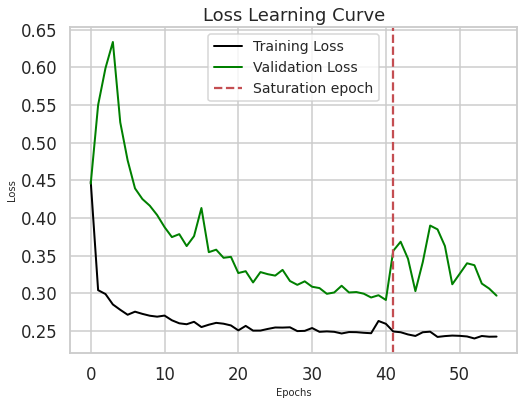

In [ ]:
# Loss Learning Curve
plt.figure(figsize=(8,6))
plt.title('Loss Learning Curve')
plt.plot(df_hist.loss, label='loss', color='black', linewidth=2.0)
plt.plot(df_hist.val_loss, label='val_loss', color='green', linewidth=2.0)
plt.axvline(x=df_hist.shape[0]-patience_epoch, color='r', linestyle='--',label='best epoch')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(['Training Loss', 'Validation Loss', 'Saturation epoch'], fontsize=14)
# plt.savefig('figure/learning_curve_0810')
plt.show()

In [ ]:
# Test Data Evaluation
test_loss = model.evaluate(X_test,X_test)
print('test loss :',np.round(test_loss,4))

1/1 [==============================] - 0s 42ms/step - loss: 0.2561
test loss : 0.2561


In [ ]:
# Test Data Prediction(Reconstruction)
X_pred = model.predict(X_test)
X_pred.shape,round(X_pred.mean(),4)

((25, 128, 128, 3), 0.8263)

<Figure size 432x288 with 0 Axes>

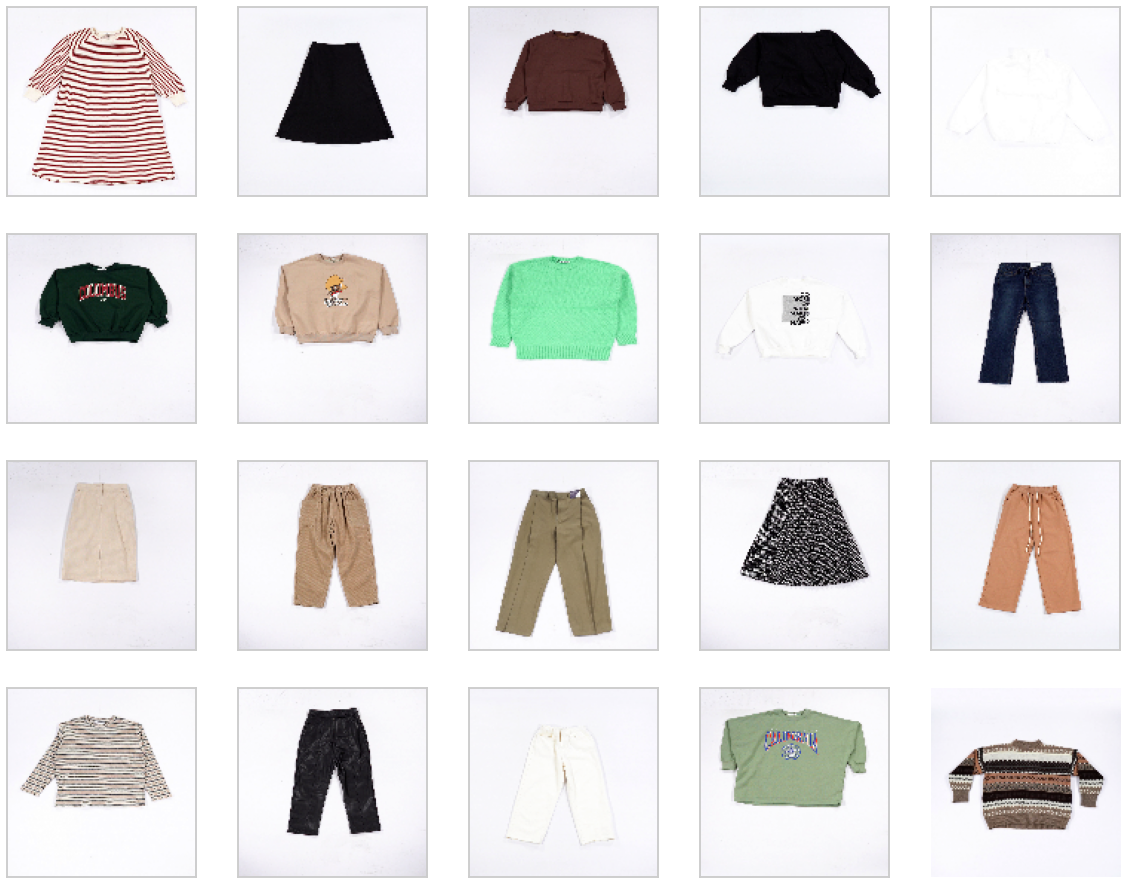

In [ ]:
# Test Image Samples
_ = plot_images(4,5,X_test)

<Figure size 432x288 with 0 Axes>

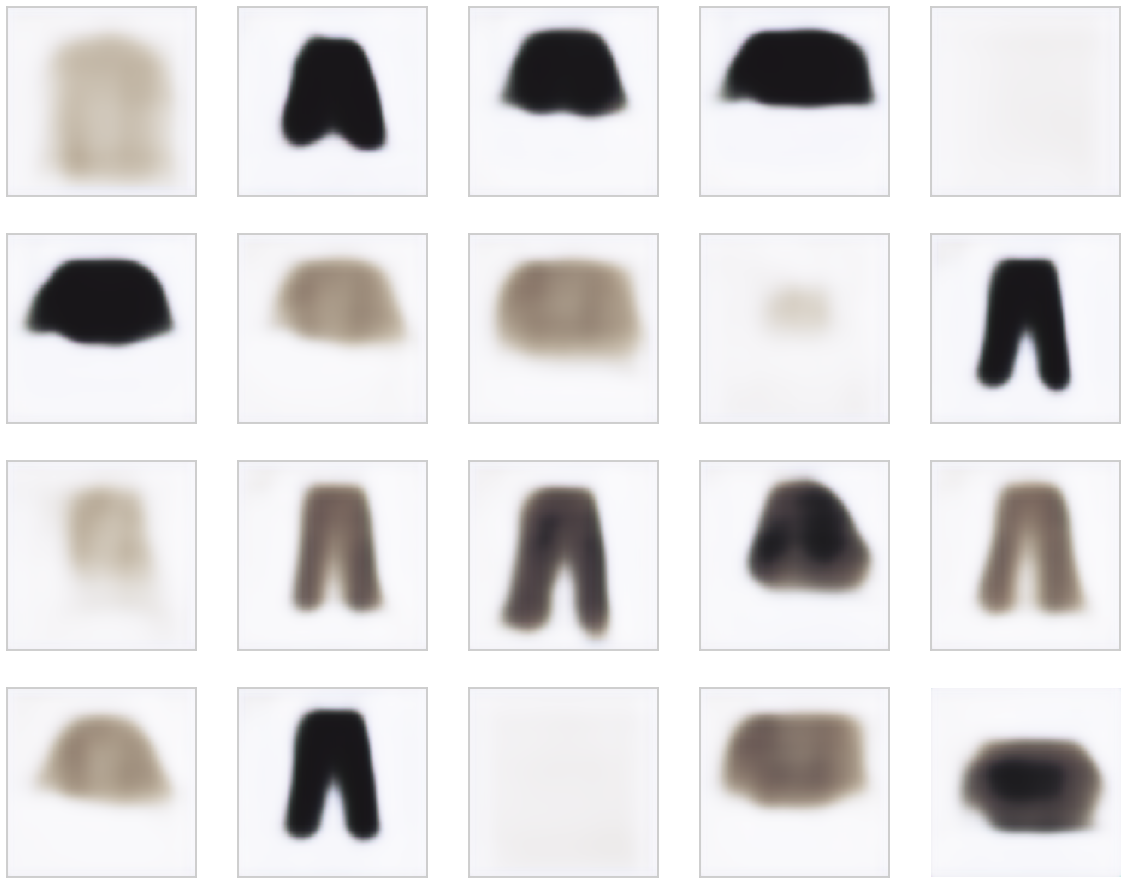

In [ ]:
# Prediction Image Samples
_ = plot_images(4,5,X_pred)

In [ ]:
# Reconstruction Error 
X_error = Reconstruction_Error(X_test,X_pred)
len(X_error), type(X_error)

(25, list)

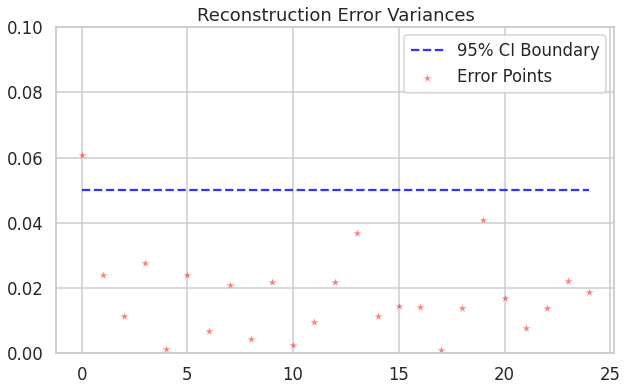

In [ ]:
# Reconstruction Error Visaulization
X_loop = np.arange(len(X_error))
boundary = 0.05

plt.figure(figsize=(10,6))
sns.scatterplot(X_loop, X_error, color = 'red', alpha=0.5, marker='*', label='Error Points')
sns.lineplot(X_loop, boundary, color='blue', linestyle='--', label='95% CI Boundary', alpha=0.8)
plt.title('Reconstruction Error Variances', size=18)
plt.legend(loc="upper right")
plt.ylim(0.00,0.10)
plt.show()

## 5. Latent Space Projection

In [ ]:
# Raw Latent Feature
raw_feature = encoder.predict(img_scaled)
raw_feature.shape, type(raw_feature)

((123, 4, 4, 8), numpy.ndarray)

In [ ]:
# Deep Compact Latent 8 Features 
latent_feature = AVGpooling(raw_feature)
latent_feature.shape, type(latent_feature)

((123, 8), numpy.ndarray)

In [ ]:
# Latent Feature DataFrame
comp_list = ['comp1','comp2','comp3','comp4','comp5','comp6','comp7','comp8','label']
df = pd.DataFrame(latent_feature)
df = pd.concat([df,pd.Series(label_set)],axis=1)
df.columns = comp_list
print('df.shape :',df.shape)
df.head()

df.shape : (123, 9)


,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,label
0,34.040878,145.604584,0.0,0.0,61.629307,16.589731,16.647583,0.0,1008002_F.jpg
1,35.334709,141.641388,0.0,0.0,67.935143,18.818481,16.165777,0.0,1008003_F.jpg
2,35.201431,152.208313,0.0,0.0,62.469646,15.776122,15.384466,0.0,1012144_F.jpg
3,36.678604,142.485077,0.0,0.0,61.590675,18.673506,17.165613,0.0,1012188_F.jpg
4,33.773537,162.597290,0.0,0.0,59.030708,13.190264,14.775338,0.0,1014067_F.jpg


In [ ]:
# Latent Feature DataFrame export to csv
df.to_csv('latent feature/latent_feature_0812.csv',index=False)

## 6. Similarity Calculation & Top10 Item Return

In [ ]:
# Latent Feature DataFrame load
df = pd.read_csv('latent feature/latent_feature_0812.csv')
print(df.shape)
df.head()

(246, 9)


,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,label
0,6.362413,7.204960,6.712477,3.069040,2.248218,4.778825,4.486508,4.051155,1008002_B.jpg
1,6.286437,7.256262,6.852417,3.082098,2.220927,4.741458,4.455274,4.118773,1008002_F.jpg
2,5.745501,6.916761,7.267769,3.113491,1.730403,4.052023,4.648100,3.922748,1008003_B.jpg
3,5.671057,6.774330,7.098071,3.115021,1.770521,4.050430,4.631084,3.894664,1008003_F.jpg
4,5.606778,4.285109,6.150334,2.278476,1.657006,3.519908,4.820201,2.895538,1012144_B.jpg


In [ ]:
# Latent Feature Data & Label Split
data = df.drop('label',axis=1)
label = df['label']
print(data.shape, label.shape)

(246, 8) (246,)


### Cosine Similarity

In [ ]:
# Cosine Similarity Computation
cosine_matrix = cosine_similarity(data, data)
print('cosine_matrix.shape :',cosine_matrix.shape)
cosine_matrix[:4,:4]

cosine_matrix.shape : (246, 246)


array([[1.        , 0.99992221, 0.99646817, 0.99688655],
       [0.99992221, 1.        , 0.99717408, 0.99751525],
       [0.99646817, 0.99717408, 1.        , 0.99995117],
       [0.99688655, 0.99751525, 0.99995117, 1.        ]])

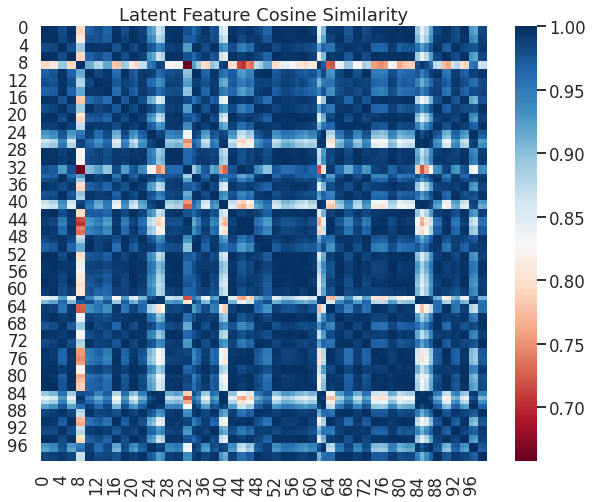

In [ ]:
# Cosine Similarity Visualization
plt.figure(figsize=(10,8))
plt.title('Latent Feature Cosine Similarity')
sns.heatmap(cosine_matrix[:100, :100], cmap='RdBu')
plt.show()

In [ ]:
# 기존 이미지 중 단일 샘플 추출
sample_idx = np.random.choice(np.arange(df.shape[0]),1)[0]
sample = data.loc[sample_idx,:].values.reshape(1,-1)
print('sample_idx :',sample_idx)

In [ ]:
# 기존 이미지 중 단일 샘플에 대한 코사인 유사도 계산식
sample_cosine_sim = cosine_similarity(sample, data)

print('sample_cosine_sim.shape :',sample_cosine_sim.shape)

sample_idx : 235
sample_cosine_sim.shape : (1, 246)


smp.shape : (64, 64, 3)
sample_cosine_sim.shape : (1, 246)



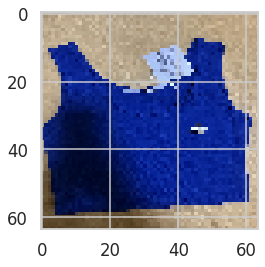

In [ ]:
# # 새로운 이미지 중 단일 샘플에 대한 코사인 유사도 계산식
# smp = New_image_preprocessing('sample.jpg')
# smp_emb = encoder.predict(np.reshape(smp,(1,64,64,3)))
# smp_comp = AVGpooling(smp_emb)
# print('smp.shape :',smp.shape)
# plt.imshow(smp)

# sample_cosine_sim = cosine_similarity(smp_comp, data)
# print('sample_cosine_sim.shape :',sample_cosine_sim.shape)
# print()

In [ ]:
# Define Sample Similarity DataFrame
df_cosine = pd.DataFrame(sample_cosine_sim.T, index=df.index, columns=['sample'])
print('df_cosine.shape :',df_cosine.shape)
df_cosine.head(4)

df_cosine.shape : (246, 1)


,sample
0,0.997302
1,0.997068
2,0.996273
3,0.996547


In [ ]:
# Return Top10 Similar Items
top10_idx_cosine = df_cosine['sample'].nlargest(10).index
print('top10_idx_cosine :',top10_idx_cosine)
print(label[top10_idx_cosine].values)

top10_idx_cosine : Int64Index([235, 234, 204, 139, 205, 186, 192, 79, 187, 56], dtype='int64')
['1209174_F.jpg' '1209174_B.jpg' '1127316_B.jpg' '1116482_F.jpg'
 '1127316_F.jpg' '1125302_B.jpg' '1126177_B.jpg' '1102128_F.jpg'
 '1125302_F.jpg' '1027106_B.jpg']


1209174_F.jpg


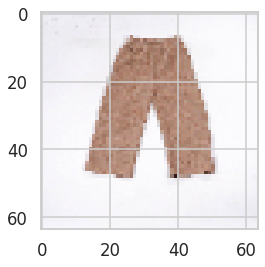

In [ ]:
# 기존 이미지 중 단일 샘플 이미지
print(df.loc[sample_idx,'label'])
_ = plt.imshow(img_set[sample_idx])

<Figure size 432x288 with 0 Axes>

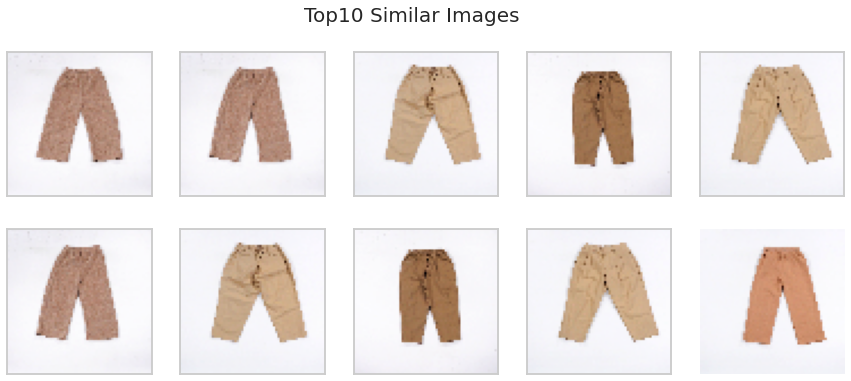

In [ ]:
# Top10 유사 이미지 시각화
top10_visualize(img_set,top10_idx_cosine)

### Euclidean Distance Calculation

In [ ]:
# Euclidean Distance Calculation
ec_matrix = 1 / euclidean_distances(data, data)
print('ec_matrix.shape :',ec_matrix.shape)
ec_matrix[:4,:4]

ec_matrix.shape : (246, 246)


array([[       inf, 5.28170709, 0.78739211, 0.78607266],
       [5.28170709,        inf, 0.85344928, 0.83510398],
       [0.78739211, 0.85344928,        inf, 4.17688627],
       [0.78607266, 0.83510398, 4.17688627,        inf]])

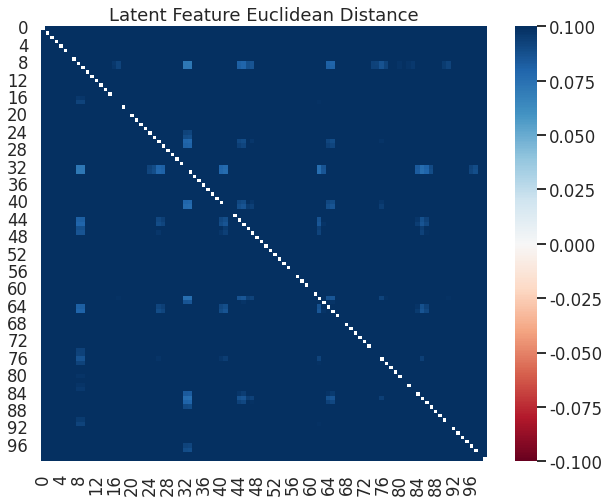

In [ ]:
# Euclidean Distance Visualization
plt.figure(figsize=(10,8))
plt.title('Latent Feature Euclidean Distance')
sns.heatmap(ec_matrix[:100, :100], cmap='RdBu')
plt.show()

In [ ]:
# 기존 이미지 중 단일 샘플에 대한 유클리디안 거리 계산식
sample_ec_distance = 1 / euclidean_distances(sample, data)

print('sample_ec_distance.shape :',sample_ec_distance.shape)

sample_ec_distance.shape : (1, 246)


In [ ]:
# Define Sample Similarity DataFrame
df_ec = pd.DataFrame(sample_ec_distance.T, index=df.index, columns=['sample'])
print('df_ec.shape :',df_ec.shape)
df_ec.head(4)

df_ec.shape : (246, 1)


,sample
0,0.720602
1,0.686120
2,0.765046
3,0.839613


In [ ]:
# Return Top10 Similar Items
top10_idx_ec = df_ec['sample'].nlargest(10).index
print('top10_idx_ec :',top10_idx_ec)
print(label[top10_idx_ec].values)

top10_idx_ec : Int64Index([235, 204, 234, 205, 138, 139, 193, 187, 20, 186], dtype='int64')
['1209174_F.jpg' '1127316_B.jpg' '1209174_B.jpg' '1127316_F.jpg'
 '1116482_B.jpg' '1116482_F.jpg' '1126177_F.jpg' '1125302_F.jpg'
 '1019386_B.jpg' '1125302_B.jpg']


1209174_F.jpg


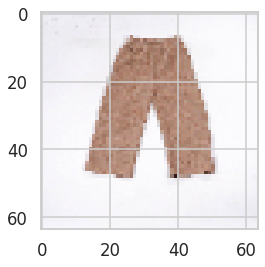

In [ ]:
# 기존 이미지 중 단일 샘플 이미지
print(df.loc[sample_idx,'label'])
_ = plt.imshow(img_set[sample_idx])

<Figure size 432x288 with 0 Axes>

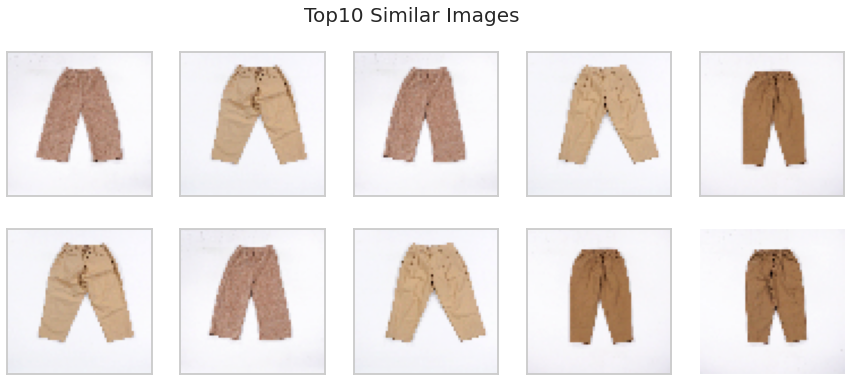

In [ ]:
# Top10 유사 이미지 시각화
top10_visualize(img_set,top10_idx_ec)

### Pearson Similarity

In [ ]:
# Pearson Similarity Computation
pearson_sim = np.corrcoef(data.to_numpy())
print('pearson_sim.shape :',pearson_sim.shape)
pearson_sim[:4,:4]

pearson_sim.shape : (246, 246)


array([[1.        , 0.9993091 , 0.9736955 , 0.97452449],
       [0.9993091 , 1.        , 0.97920826, 0.97973019],
       [0.9736955 , 0.97920826, 1.        , 0.99993591],
       [0.97452449, 0.97973019, 0.99993591, 1.        ]])

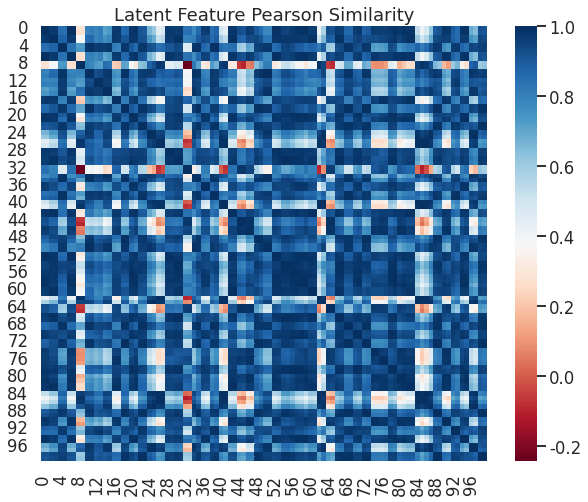

In [ ]:
# Pearson Similarity Visualization
plt.figure(figsize=(10,8))
plt.title('Latent Feature Pearson Similarity')
sns.heatmap(pearson_sim[:100, :100], cmap='RdBu')
plt.show()

In [ ]:
# 기존 이미지 중 단일 샘플에 대한 코사인 유사도 계산식
sample_pearson_sim = np.corrcoef(x=data.to_numpy(),y=sample)

print('sample_pearson_sim.shape :',sample_pearson_sim.shape)

sample_pearson_sim.shape : (247, 247)


In [ ]:
# Define Sample Similarity DataFrame
df_pearson = pd.DataFrame(sample_pearson_sim[-1,:-1], index=df.index, columns=['sample'])
print('df_pearson.shape :',df_pearson.shape)
df_pearson.head(4)

df_pearson.shape : (246, 1)


,sample
0,0.982054
1,0.979270
2,0.970446
3,0.972500


In [ ]:
# Return Top10 Similar Items
top10_idx_pearson = df_pearson['sample'].nlargest(10).index
print('top10_idx_pearson :',top10_idx_pearson)
print(label[top10_idx_pearson].values)

top10_idx_pearson : Int64Index([235, 234, 204, 139, 205, 79, 56, 186, 192, 193], dtype='int64')
['1209174_F.jpg' '1209174_B.jpg' '1127316_B.jpg' '1116482_F.jpg'
 '1127316_F.jpg' '1102128_F.jpg' '1027106_B.jpg' '1125302_B.jpg'
 '1126177_B.jpg' '1126177_F.jpg']


1209174_F.jpg


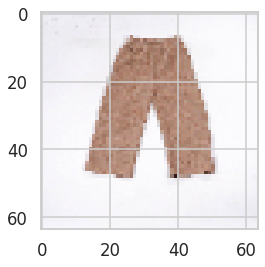

In [ ]:
# 기존 이미지 중 단일 샘플 이미지
print(df.loc[sample_idx,'label'])
_ = plt.imshow(img_set[sample_idx])

<Figure size 432x288 with 0 Axes>

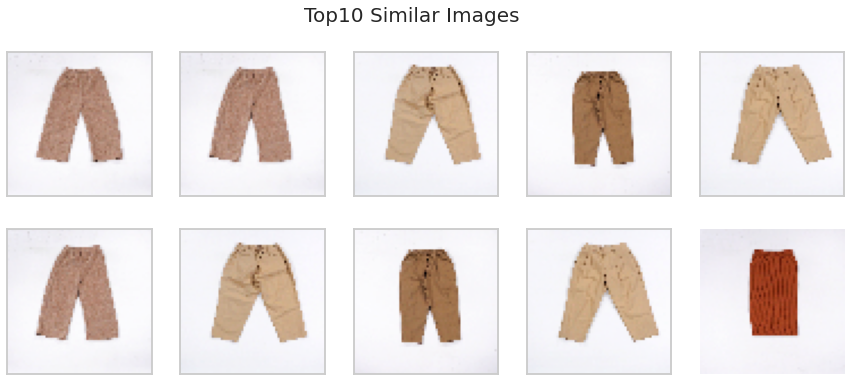

In [ ]:
# Top10 유사 이미지 시각화
top10_visualize(img_set,top10_idx_pearson)

## 7. Fashion Coordination Recommendation